# Challenge - Wikipedia Question Answering

## Objective

“Why is the sky blue?”

This is the type of questions an **open-domain question answering (QA) system** should be able to respond to. QA systems emulate how people look for information, by reading the web to return answers to common questions. Machine learning can be used to improve the accuracy of those answers.

Existing natural language models have been focused on extracting answers from a short paragraph rather than reading an entire page of content for proper context. As a result, the responses can be complicated or lengthy. A good answer will be both succinct and relevant.

> In this challenge, your goal is to **predict short** and **long answer responses** to real questions about Wikipedia articles. The dataset is provided by [Google's Natural Questions](https://ai.google.com/research/NaturalQuestions/dataset) and available [here](https://www.kaggle.com/c/tensorflow2-question-answering/data).

To better understand the data and the 2 types of answers to predict, you can have a look at this [visualization](https://ai.google.com/research/NaturalQuestions/visualization).

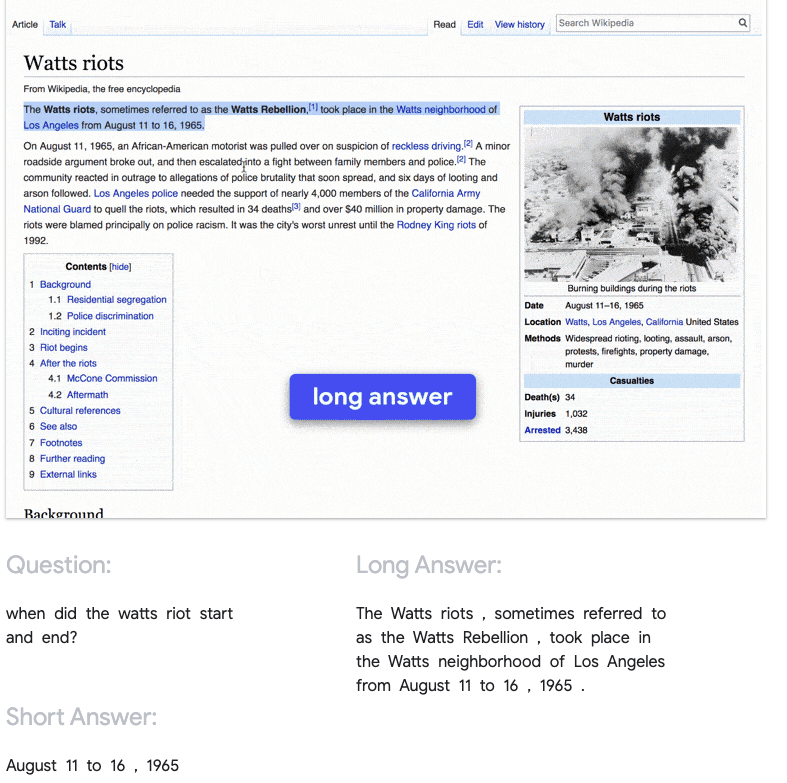

From a question, we will predict both types of answers, using BERT based models. More precisely:
- We will fine tune Bert for **binary classification** in order to predict **long answers**, i.e. the paragraph from the Wikipedia webpage containing the answer to the given question
- We will fine tune Bert for **question-answering** in order to predict **short answers**

⚠️ **Please make sure you have a GPU runing behind your colab session**. Go to *Execution*, *Modifier le type d'exécution* and select **GPU** in *Accélérateur matériel*.

### Get the data

The training data of this challenge are huge. Therefore, you will download them directly on collab from Kaggle.

Please follow the steps below to download and use kaggle data within Google Colab:

1. Go to your account, Scroll to API section and Click Expire **API Token** to remove previous tokens

2. Click on **Create New API Token** - It will download a `kaggle.json` file on your machine.

3. Go to your Google Colab project file and run the following commands:

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
# Choose the kaggle.json file that you downloaded

In [ ]:
# Make directory named kaggle and copy kaggle.json file there
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
# Change the permissions of the file
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset from Kaggle
! kaggle competitions download -c tensorflow2-question-answering

In [ ]:
# Unzip train and test set. This will take approximately 7 minutes
! unzip simplified-nq-test.jsonl.zip
! unzip simplified-nq-train.jsonl.zip

For this challenge, you will implement transformers using the [simpletransformers](https://simpletransformers.ai/docs/usage/) library. This library is based on the [Transformers](https://github.com/huggingface/transformers) library by HuggingFace. Simple Transformers lets you quickly train and evaluate Transformer models. Only 3 lines of code are needed to initialize a model, train the model, and evaluate a model.

After installing the simpletransformer library, you will need to restart your execution environment.

In [ ]:
# TODO : Install simpletransformers library

### Read data

The data for this task comes in a rather complex form. The raw data is in a jsonl file with each line of jsonl containing the following:

- **question_text**: A string representing a question asked on Google.
- **document_text**: A string containing the html of the wikipedia page relevant to the question.
- **annotations/long_answer**: A json object containing the start and end index of the correct answer substring (substring of the document_text)
- annotations/short_answers**: An array of the possible short answers. Each short answer is represented as the start and end index of the substring that is within document_text).
- **long_answer_candidates**: An array of the possible long answers to the questions. These are basically the paragraphs within the wikipedia page.

We have provided below the functions necessary to load the data to a pandas DataFrame format.

In [ ]:
import json
from tqdm.notebook import tqdm

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import re

In [ ]:
def get_line_of_data(file):
    line = file.readline()
    line = json.loads(line)
    
    return line


def get_question_and_document(line):
    question = line['question_text']
    text = line['document_text'].split(' ')
    annotations = line['annotations'][0]
    
    return question, text, annotations
                
                
def get_long_candidate(i, annotations, candidate):
    # check if this candidate is the correct answer
    if i == annotations['long_answer']['candidate_index']:
        label = True
    else:
        label = False

    # get place where long answer starts and ends in the document text
    long_start = candidate['start_token']
    long_end = candidate['end_token']
    
    return label, long_start, long_end


def form_data_row(question, label, text, long_start, long_end):
    row = {
        'question': question,
        'long_answer': ' '.join(text[long_start:long_end]),
        'is_long_answer': label,
    }
    
    return row


def load_data(file_path, questions_start, questions_end):
    rows = []
    
    with open(file_path) as file:

        for i in tqdm(range(questions_start, questions_end)):
            line = get_line_of_data(file)
            question, text, annotations = get_question_and_document(line)

            for i, candidate in enumerate(line['long_answer_candidates']):
                label, long_start, long_end = get_long_candidate(i, annotations, candidate)

                if label == True or (i % SAMPLE_RATE == 0):
                    rows.append(
                        form_data_row(question, label, text, long_start, long_end)
                    )
        
    return pd.DataFrame(rows)

In [ ]:
TRAIN_PATH = "./simplified-nq-train.jsonl"
TRAINING_SIZE, VALIDATION_SIZE = 1000, 1000
SAMPLE_RATE = 15

# Read train and validation sets
train_df = load_data(TRAIN_PATH, 0, TRAINING_SIZE)
val_df = load_data(TRAIN_PATH, TRAINING_SIZE, TRAINING_SIZE+VALIDATION_SIZE)

In [ ]:
# TODO : Quick overview of the data

## Clean and tokenize the text

With the raw data loaded, it is time to clean up the data to make it easier for the model to train on.

**To keep this notebook short, we will only remove html tags.**

There are however many more that we could use to improve this model which can be found in notebooks like this [one](https://www.kaggle.com/raenish/cheatsheet-text-helper-functions). Feel free to come back to this step to improve your results later.

In [ ]:
# TODO : implement a function `remove_html` that will remove html tags from your data.
# Although there are other ways to do that, using a regex is recommended here

In [ ]:
# TODO : clean your data

### Train binary classification model

The first objective of our system is to recognize if the answer to a given question lies within a specific piece of text. This can be modeled as a binary classification task. More precisely, we can provide as input a question, a piece of text, and train a model to predict True if the answer lies in the text.

In [ ]:
# TODO : import `ClassificationModel` from `simpletransformers` library

In [ ]:
# TODO : Create a ClassificationModel
# You can use the following model arguments
model_args = {
    "num_train_epochs": 2,
    "train_batch_size": 16
    }

# Use the `bert-base-cased` model
# All possible parameters available here: https://simpletransformers.ai/docs/classification-models/

In [ ]:
# TODO : check out the methods of your model : one of them will allow you to display its structure

One way to train a model using this library is to create a pandas DataFrame with 2 columns: text to classify and the corresponding label.

In our case, **the text will be made of the question and the candidate text** (potentially containing the answer to the question).

Remember that BERT has been trained using a **[SEP]** separator separating 2 sentences used for the **is next sentence** task. We can leverage on this **[SEP]** token in order to separate the question from the text.
The final piece of pre-processing to be done is to create an array of binary labels for the model. The labels were boolean values in the model so they need to be converted to 0-1 integers as the model prefers them that way.

⚠️ **In other words**, we want to create a train dataframe and a val dataframe, each containing two columns :
- a column `text`, containing, for each sample, **the text of the question, then the token \[SEP\], then the text of the long answer**. 
> **Example** : `"when did the watts riot start and end? [SEP] The Watts riots, sometimes referred to as the Watts Rebellion, took place in the Watts neighborhood of Los Angeles from August 11 to 16, 1965."`

- a column `label`, containing 0 if the candidate text is **not** the long answer, and 1 if it is.

In [ ]:
# TODO : Create your `train_df` and your `val_df`

We can now train our Transformer classifier.

In [2]:
# TODO : Train the model

In [3]:
# TODO : Evaluate the model

In [4]:
# TODO : accuracy score

You can test your system on new questions and webpages from the test dataset.

In [ ]:
def load_test_data(file_path, questions_start, questions_end):
    rows = []
    
    with open(file_path) as file:

        for i in tqdm(range(questions_start, questions_end)):
            paragraphs = []
            line = get_line_of_data(file)
            question, text = line['question_text'], line['document_text'].split(' ')

            for i, candidate in enumerate(line['long_answer_candidates']):
              long_start = candidate['start_token']
              long_end = candidate['end_token']
              paragraphs.append(' '.join(text[long_start:long_end]))
              
            rows.append({'question': question, 'text': paragraphs})
        
    return pd.DataFrame(rows)

In [ ]:
SUBMISSION_PATH = "./simplified-nq-test.jsonl"
test_df = load_test_data(TRAIN_PATH, 0, 10)

The text column is made of a list of paragraphs from Wikipedia webpage, potential candidates as long answers.

Now, let's predict the answer from the first question and wikipedia webpage.

In [ ]:
IDX = 7
question, paragraphs = test_df.iloc[IDX].question, test_df.iloc[IDX].text
answers, output = model.predict([question + " [SEP] " + remove_html(candidate) for candidate in paragraphs])

In [ ]:
from IPython.core.display import display, HTML

print("Question was: {}".format(question))
print("---")
print("Predicted long answer is:")
for answer_idx in np.where(answers==1)[0]:
  display(HTML(paragraphs[answer_idx]))

#### Todo : Play with your model a bit, and try to get the predicted answers to other questions in the test dataset :)

-----

## Train Question-Answering model

**With the correct long answer extracted, the next challenge is to extract the short answer from a long answer**. So if the correct answer is a paragraph about who the mother in **"How I met your mother"** is:

> "Tracy McConnell, better known as 'The Mother', is the title character from the CBS television sitcom How I Met Your Mother. The show, narrated by Future Ted, tells the story of how Ted Mosby met The Mother. Tracy McConnell appears in 8 episodes from 'Lucky Penny' to 'The Time Travelers' as an unseen character; she was first seen fully in 'Something New' and was promoted to a main character in season 9. The Mother is played by Cristin Milioti."

The correct short answer would be the mother's name:

> "Tracy McConnell"

The approach to this challenge isn't too different from what we just did, and the pre-processing will stay the same. Then :
- first we will **load the dataset filtering out the wrong long answers** and **extracting the start and end index of the short answer within the long answer**. 
- **The start and end index are the indexes of the words in the long answer that make up the short answer**. So if we use the same example answer above, the start and end index would be 0 and 2 as the short answer begins on the first word of the long answer and ends after the second word.

In [ ]:
def get_short_answer(annotations, long_start, long_end):
    if len(annotations['short_answers']) > 0:
        short_start = annotations['short_answers'][0]['start_token']
        short_end = annotations['short_answers'][0]['end_token']
        
        short_start = short_start - long_start
        short_end = short_end - long_start
        
        return short_start, short_end
    else:
        return 0, 0
    

def form_short_data_row(question, text, long_start, long_end, short_start, short_end):
    long_answer = ' '.join(text[long_start:long_end])
    short_answer = ' '.join(long_answer.split(' ')[short_start:short_end])
    
    row = {
        'question': question,
        'long_answer': long_answer,
        'short_answer': short_answer,
        'short_start': short_start,
        'short_end': short_end
    }
    
    return row


def load_short_data(file_path, questions_start, questions_end):
    rows = []
    
    with open(file_path) as file:

        for i in tqdm(range(questions_start, questions_end)):
            line = get_line_of_data(file)
            question, text, annotations = get_question_and_document(line)

            for i, candidate in enumerate(line['long_answer_candidates']):
                label, long_start, long_end = get_long_candidate(i, annotations, candidate)

                if label == True:
                    short_start, short_end = get_short_answer(annotations, long_start, long_end)
                    
                    rows.append(
                        form_short_data_row(question, text, long_start, long_end, short_start, short_end)
                    )
        
    return pd.DataFrame(rows)

In [ ]:
TRAIN_PATH = "./simplified-nq-train.jsonl"
TRAINING_SIZE, VALIDATION_SIZE = 1000, 1000

train_short_df = load_short_data(TRAIN_PATH, 0, TRAINING_SIZE)
val_short_df = load_short_data(TRAIN_PATH, TRAINING_SIZE, TRAINING_SIZE+VALIDATION_SIZE)

In [ ]:
train_short_df.head()

In order to train the question answering model, we need to put the data into the right format.

In [ ]:
def reformat_qa_data(data):

  data["is_impossible"] = data.short_end==0
  data["context"] = data.long_answer.apply(lambda x: remove_html(x))  

  train_data = []
  for idx, row in data.iterrows():
    if row.is_impossible:
      train_data.append(
              {
          "context": row.context,
          "qas": [
                   {
                      "id": str(idx),
                      "is_impossible": row.is_impossible,
                      "question": row.question,
                      "answers": [],
                  }
                ],
              },
      )
    else:
      train_data.append(
              {
          "context": row.context,
          "qas": [
                   {
                      "id": str(idx),
                      "is_impossible": row.is_impossible,
                      "question": row.question,
                      "answers": [                    
                                  {
                          "text": row.short_answer,
                          "answer_start": row.context.find(row.short_answer),
                          }
                      ],
                  }
                ],
              },
      )

  return train_data

In [ ]:
train_short_df = reformat_qa_data(train_short_df)
val_short_df = reformat_qa_data(val_short_df)

Now, let's train our question-answering model

In [5]:
# TODO : Import `QuestionAnsweringModel` from `simpletransformers` library

In [6]:
# TODO : Create a QuestionAnsweringModel
# You can use the following model arguments
model_args = {
    "num_train_epochs": 4,
    "train_batch_size": 16,
    "n_best_size": 1,
    "overwrite_output_dir": True # To overwrite classification model saved in the output directory
}

# Use a "bert-base-cased" model
# All available arguments available here: https://simpletransformers.ai/docs/qa-model/

In [ ]:
# TODO : Train the model

In [7]:
# TODO : Evaluate the model

In [8]:
# What's the accuracy ?

### Let's try our system

Now let's link all parts of our system in order to find answer to a question from a Wikipedia webpage.

In [9]:
# TODO : Choose randomly a Wikipedia article and a question relating to it

IDX = # random choice
question, paragraphs = test_df.iloc[IDX].question, test_df.iloc[IDX].text

In [ ]:
# Let's display the article and the afferent question
print("Article:")
print("---")
display(HTML(" ".join(paragraphs)))
print("xxxxxx")
print("xxxxxx")
print("Question:")
print("---")
print(question)

First, we need to get the paragraphs containing the answer.

In [ ]:
answers, output = model.predict([question + " [SEP] " + remove_html(candidate) for candidate in paragraphs])

Now, we need to extract the short answer from this paragraph using our question-answering model.


In [ ]:
# Make predictions with the question-answering model
to_predict = [
    {
        "context": remove_html(paragraphs[answer_idx]),
        "qas": [
            {
                "question": question,
                "id": "0",
            }
        ],
    }
]

answers, probabilities = qa_model.predict(to_predict)

In [10]:
# TODO : Display your model's answer !

Try to play some more with your model : hyperparameters tuning, better preprocessing, etc.